In [1]:
using DataFrames
using CSV
using Plots
using Interpolations
using Statistics
using StatsBase
using FFTW
using DSP
using LinearAlgebra


In [2]:
struct PeriodicArray{T}
    data::Vector{T}
end

# Define el método length para PeriodicArray
Base.length(arr::PeriodicArray) = length(arr.data)

# Redefine el método getindex para acceso cíclico
Base.getindex(arr::PeriodicArray, i::Int) = arr.data[mod1(i, length(arr.data))]


function k_c(L, epsilon=1, Dif=1)
    pm=1
    if L<1
        pm=-1
    end
    return (pi + 0.5*pi*(1 - pm*(sqrt(4*Dif + (L^2)*epsilon))/(L*sqrt(epsilon)))) / L
end


k_c (generic function with 3 methods)

In [5]:
################## Parametros ###################################

# Discretización en el espacio y el tiempo
dx = 0.1
dt = 0.005

#Experimentales
at = 3.3 # acomplamiento traslacional 
eta= 0.0      # Coef.Antisimetrico
epsilon=1.     # Bifurcación
alpha = 1     # Coeficiente de difusión


################### Condiciones Iniciales #########################

# Función de la condición inicial.
kc=k_c(at)
σ= 30
u0(x) = sqrt(epsilon) #+ 0.1*cos(kc*x) #+ 0.1*exp(-((x)^2) / (2 * σ^2))*cos(kc*x)


# Tamaño simulación
L = (2*pi/kc) * 20      # Largo de la caja
T = 200.0        # Tiempo total de simulación
Nx = round(Int, L / dx)      # Número de puntos en el espacio
Nt =  round(Int, T/dt )    # Número de pasos de tiempo  



# Espacio en el que se define la Función
x = (-Nx)/2:(Nx/2-1)
x=x*dx

# Evaluar la funcion en ese mismo espacio con el detalle que sea en funcion a la discretizacion dx.
u = [u0(i) for i in x] ;
ruido = 0.001 * randn(length(u))*0
u .= u .+ ruido;

u_i= u;

In [140]:
# Cálculo de variables necesarias
expa = div(Nx, 2)  # Usa div en lugar de round para mejorar claridad y rendimiento
x_expa = (-Nx/2 - expa):(Nx/2 - 1 + expa)
x_expa = x_expa * dx

function f(u, alpha=alpha, eta=eta, epsilon=epsilon)
    # Inicialización del vector de derivadas
    du = similar(u)
    
    # Crear una versión periódica del vector u usando el tipo PeriodicArray
    pu = PeriodicArray(u)
    
    # Crear el vector expandido usando la periodicidad
    expanded_u = vcat([pu[i] for i in 1-expa:length(u)+expa])
    
    # Interpolación cúbica sobre el vector expandido
    itp = CubicSplineInterpolation(x_expa, expanded_u)
    
    # Cálculo de la derivada en cada punto
    for i in 1:Nx
        xi = x_expa[i + expa]  # Índice correspondiente en x_expa
        du[i] = eta + epsilon * itp(xi - at) - itp(xi - at)^3 +
                alpha * (itp(xi + dx) - 2 * itp(xi) + itp(xi - dx)) / dx^2
    end
    
    return du
end

# 2.2 Método de Runge-Kutta de orden 4
function runge_kutta_4(u, dt)
    k1 = f(u)
    k2 = f(u + 0.5 * dt * k1 )
    k3 = f(u + 0.5 * dt * k2)
    k4 = f(u + dt * k3)
    u_new = u + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) 
    return u_new
end

runge_kutta_4 (generic function with 1 method)

In [142]:
result = Matrix{Float64}(undef, Nt+1, Nx)
result[1, :] = u



1442-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [148]:
for t in 1:Nt
    u = runge_kutta_4(u, dt)  # pasa los parámetros
    result[t+1, :] = u
end

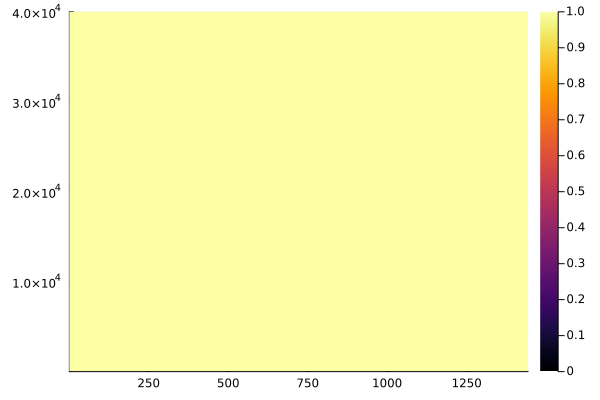

In [149]:
heatmap(result)

In [160]:
function calcular_LLE(u0, dt, Nt, δ=1e-8, pasos=1000)
    # Perturbamos levemente la condición inicial
    δu0 = δ * randn(length(u0))
    u1 = copy(u0)
    u2 = u0 .+ δu0
    distancia0 = norm(δu0)

    suma_log = 0.0
    n = 0

    for t in 1:Nt
        # Evolucionamos ambos sistemas
        u1 = runge_kutta_4(u1, dt)
        u2 = runge_kutta_4(u2, dt)

        if t % pasos == 0
            # Calculamos la diferencia
            δu = u2 .- u1
            distancia = norm(δu)

            # Acumulamos el logaritmo del crecimiento
            suma_log += log(distancia / distancia0)
            n += 1

            # Renormalizamos la perturbación
            δu = δ * δu / distancia
            u2 = u1 .+ δu
        end
    end

    return suma_log / (n * dt * pasos)
end

calcular_LLE (generic function with 3 methods)

In [162]:
lle = calcular_LLE(result[1, :], dt, Nt)
println("LLE = ", lle)

LLE = 0.45046052621318244


# Barrido

In [62]:
struct PeriodicArray{T}
    data::Vector{T}
end

# Define el método length para PeriodicArray
Base.length(arr::PeriodicArray) = length(arr.data)

# Redefine el método getindex para acceso cíclico
Base.getindex(arr::PeriodicArray, i::Int) = arr.data[mod1(i, length(arr.data))]


function k_c(L, epsilon=1, Dif=1)
    pm=1
    if L<1
        pm=-1
    end
    return (pi + 0.5*pi*(1 - pm*(sqrt(4*Dif + (L^2)*epsilon))/(L*sqrt(epsilon)))) / L
end



function f(u, alpha=alpha, eta=eta, epsilon=epsilon)
    # Inicialización del vector de derivadas
    du = similar(u)
    
    # Crear una versión periódica del vector u usando el tipo PeriodicArray
    pu = PeriodicArray(u)
    
    # Crear el vector expandido usando la periodicidad
    expanded_u = vcat([pu[i] for i in 1-expa:length(u)+expa])
    
    # Interpolación cúbica sobre el vector expandido
    itp = CubicSplineInterpolation(x_expa, expanded_u)
    
    # Cálculo de la derivada en cada punto
    for i in 1:Nx
        xi = x_expa[i + expa]  # Índice correspondiente en x_expa
        du[i] = eta + epsilon * itp(xi - at) - itp(xi - at)^3 +
                alpha * (itp(xi + dx) - 2 * itp(xi) + itp(xi - dx)) / dx^2
    end
    
    return du
end

# 2.2 Método de Runge-Kutta de orden 4
function runge_kutta_4(u, dt)
    k1 = f(u)
    k2 = f(u + 0.5 * dt * k1 )
    k3 = f(u + 0.5 * dt * k2)
    k4 = f(u + dt * k3)
    u_new = u + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) 
    return u_new
end



runge_kutta_4 (generic function with 1 method)

In [176]:
function calcular_LLE(u0, dt, Nt, δ=1e-8, pasos=1000)
    # Perturbamos levemente la condición inicial
    δu0 = δ * randn(length(u0))
    u1 = copy(u0)
    u2 = u0 .+ δu0
    distancia0 =  δ 

    suma_log = 0.0
    n = 0

    for t in 1:Nt
        # Evolucionamos ambos sistemas
        u1 = runge_kutta_4(u1, dt)
        u2 = runge_kutta_4(u2, dt)

        if t % pasos == 0
            # Calculamos la diferencia
            δu = u2 .- u1
            distancia = norm(δu)

            # Acumulamos el logaritmo del crecimiento
            suma_log += log(distancia / distancia0)
            n += 1

            # Renormalizamos la perturbación
            δu = distancia0 * δu / distancia
            u2 = u1 .+ δu
        end
    end

    return suma_log / (n * dt * pasos)
end

calcular_LLE (generic function with 3 methods)

In [171]:
lle = calcular_LLE(result[1, :], dt, Nt)
println("LLE = ", lle)

LLE = 1.1718678853323894


In [178]:
barrido = 1.4:0.1:3.30

L_lyapunov=[]
Lle_lyapuniv=[]

for i in barrido
    ################## Parametros ###################################

    # Discretización en el espacio y el tiempo
    dx = 0.1
    dt = 0.005

    #Experimentales
    at = i # acomplamiento traslacional
    eta= 0.0      # Coef.Antisimetrico
    epsilon=1.     # Bifurcación
    alpha = 1     # Coeficiente de difusión


    ################### Condiciones Iniciales #########################

    # Función de la condición inicial.
    kc=k_c(at)
    u0(x) = sqrt(epsilon) #+ 0.1*cos(kc*x)


    # Tamaño simulación
    L = (2*pi/kc) * 20      # Largo de la caja
    T = 200.0        # Tiempo total de simulación
    Nx = round(Int, L / dx)      # Número de puntos en el espacio
    Nt =  round(Int, T/dt )    # Número de pasos de tiempo  


    # Espacio en el que se define la Función
    x = (-Nx)/2:((Nx)/2 -1)
    x=x*dx

    # Evaluar la funcion en ese mismo espacio con el detalle que sea en funcion a la discretizacion dx.
    u = [u0(i) for i in x] 
    
    # Cálculo de variables necesarias
    expa = div(Nx, 2)  # Usa div en lugar de round para mejorar claridad y rendimiento
    x_expa = (-Nx/2 - expa):(Nx/2 - 1 + expa)
    x_expa = x_expa * dx
    
    result = Matrix{Float64}(undef, Nt+1, Nx)
    result[1, :] = u

    lle = calcular_LLE(result[1, :], dt, Nt)
    
    push!(L_lyapunov, i)
    push!(Lle_lyapuniv, lle)
    
end

df = DataFrame(L=L_lyapunov , Lle=Lle_lyapuniv )
CSV.write("Datos_Lyapunov_5.csv", df)

"Datos_Lyapunov_5.csv"

 Lypunov 1 codigo normal perturvado
 lypunov 2 codigo Ale sin pertubacion
 Lyapunov 3 codigo normal sin perrubacion
 Lyapunov 4 codigo Ale con perturbación
 lypunov 5 codigo renormalización fija sin perturbacion
 lypunov 6 codigo renormalización fija con perturbacion

In [69]:
ruta_archivo = "Datos_lyapunov_2.csv"

### 2. Carga el archivo CSV y conviértelo en un objeto CSV.File
datos_csv = CSV.File(ruta_archivo) |> DataFrame
L =datos_csv[!,1]
lle= datos_csv[!,2]


33-element Vector{Float64}:
 -2.001723219944403
 -2.009683656912253
 -2.0074781874832257
 -2.00822286458857
 -2.0146767109674504
 -2.013065065071327
 -2.0059182056203415
 -2.0180262495086807
 -2.0100887346370047
 -2.010962610589163
 -1.9181149881556576
 -1.7129410008390524
 -1.4652519623125753
  ⋮
 -0.01472780294849604
 -0.013078851691802434
 -0.011946537206879502
 -0.0053267098058898945
 -0.014358693180081374
  0.031182483391800058
  0.04559089931575304
  0.08673819035285528
  0.20267001738708834
  0.20608144578181908
  0.2432344215428395
  0.2828200121297308

 Lypunov 1 codigo normal perturvado
 lypunov 2 codigo Ale sin pertubacion
 Lyapunov 3 codigo normal sin perrubacion
 Lyapunov 4 codigo Ale con perturbación
 lypunov 5 codigo renormalización fija sin perturbacion
 lypunov 6 codigo renormalización fija con perturbacion

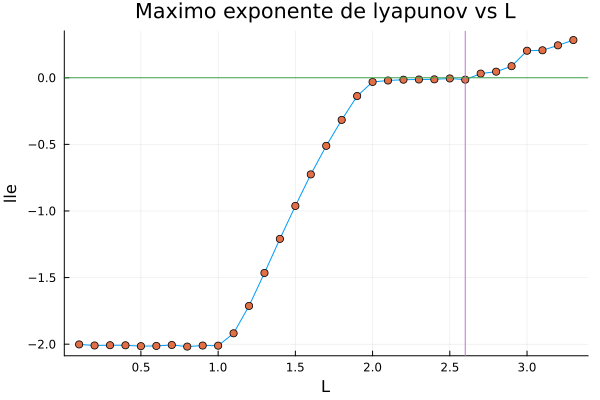

In [11]:
ruta_archivo = "Datos_lyapunov_4.csv"

### 2. Carga el archivo CSV y conviértelo en un objeto CSV.File
datos_csv = CSV.File(ruta_archivo) |> DataFrame
L =datos_csv[!,1]
lle= datos_csv[!,2]


plot(L,lle , label= false, title="Maximo exponente de lyapunov vs L" , xlabel="L" , ylabel="lle")
scatter!(L,lle, label = false)
hline!([0],label= false)
vline!([2.6], label= false)
